# Multi-Gpu Equilibrium Solve

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
num_device = 3
from desc import set_device

set_device("gpu", num_device=num_device)

In [3]:
from desc.examples import get
from desc.objectives import *
from desc.objectives.getters import *
from desc.grid import LinearGrid
from desc.backend import jnp
from desc.plotting import plot_grid

DESC version 0.13.0+1523.ge2c0f7767.dirty,using JAX backend, jax version=0.4.38, jaxlib version=0.4.38, dtype=float64
CPU Info:  AMD EPYC 7453 28-Core Processor CPU with 978.07 GB available memory
Using 3 device:
	 Device 0: NVIDIA A100-SXM4-40GB (id=0) with 40.00 GB available memory
	 Device 1: NVIDIA A100-SXM4-40GB (id=1) with 40.00 GB available memory
	 Device 2: NVIDIA A100-SXM4-40GB (id=2) with 40.00 GB available memory


In [4]:
eq = get("HELIOTRON")

In [5]:
obj = get_parallel_forcebalance(eq, num_device=num_device, check_device=False)
cons = get_fixed_boundary_constraints(eq)

Precomputing transforms
Precomputing transforms
Precomputing transforms


In [6]:
eq.solve(objective=obj, constraints=cons, maxiter=1, ftol=0, gtol=0, xtol=0, verbose=3);

Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.74 sec
Timer: Linear constraint projection build = 7.48 sec
Number of parameters: 1593
Number of objectives: 34632
Timer: Initializing the optimization = 9.34 sec

Starting optimization
Using method: lsq-exact
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:2
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.161e-07                                    1.557e-04   
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:2
       1              5 

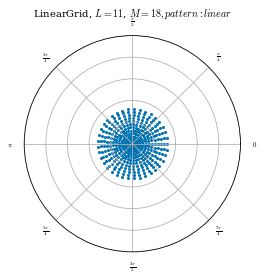

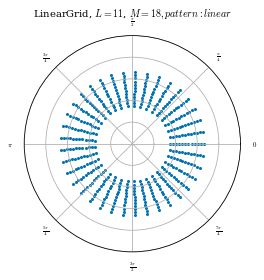

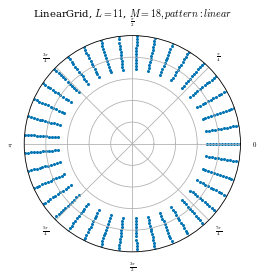

In [7]:
for obji in obj.objectives:
    plot_grid(obji.constants["transforms"]["grid"])

# Using other Objectives
Above we used the convenience function for force balance objective, but we can also other objectives with this approach. There are some extra steps you need to apply though.

In [8]:
eq = get("HELIOTRON")

In [10]:
import numpy as np
from desc.backend import jax
from desc.optimize import Optimizer

grid1 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.2, 0.4]), sym=True
)
grid2 = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)

obj1 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid1, device_id=0)
obj2 = QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid2, device_id=1)
obj3 = AspectRatio(eq=eq, target=8, weight=100, device_id=2)

objs = [obj1, obj2, obj3]
for obji in objs:
    obji.build(verbose=3)
    obji = jax.device_put(obji, jax.devices("gpu")[obji._device_id])
    obji.things[0] = eq

objective = ObjectiveFunction(objs)
objective.build(verbose=3)

Precomputing transforms
Timer: Precomputing transforms = 103 ms
Precomputing transforms
Timer: Precomputing transforms = 104 ms
Precomputing transforms
Timer: Precomputing transforms = 124 ms
Timer: Objective build = 12.9 ms


In [11]:
k = 1
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[
            np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
        ],
    )
)
Z_modes = eq.surface.Z_basis.modes[
    np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
]
constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
    FixPressure(eq=eq),
    FixPsi(eq=eq),
)
# TODO: implement for proximal
optimizer = Optimizer("lsq-exact")

In [12]:
eq.optimize(
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=1,
    verbose=3,
    options={
        "initial_trust_ratio": 1.0,
    },
);

Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 367 ms
Timer: Linear constraint projection build = 2.84 sec
Number of parameters: 1614
Number of objectives: 1236
Timer: Initializing the optimization = 3.32 sec

Starting optimization
Using method: lsq-exact
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:2
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          9.547e+04                                    3.162e+02   
This should run on GPU id:0
This should run on GPU id:1
This should run on GPU id:2
       1              6          4.883e+04      4.664e+04      5.955e+00      1.431e+02   
       